# `photutils` Annulus Background

Historically it is most widely used to estimate the sky using sky annulus. The sky (background) is estimated by following steps:

1. Set the annulus based on FWHM. 
2. Get the statistics of the sky in the annulus: sky value and its error.

## Revisit M13

I will use the M13 image again to demonstrate this. The strategy is 

1. Get FWHM from `ginga` (it was ~ 2.5 pix)
2. Find stars from `DAOStarFinder` using `500*sky_sigma` threshold. (very strong constrain)
3. Make circular annuli with inner/outer radius of `4*FWHM` and `6*FWHM`, centered at each star.
4. Do 3-sigma clipping with 10 iterations for each annulus, and get the median and standard deviation.
5. To mimic SExtractor, I will choose `sky` as 
```python
# pseudo code
mean, median, std = sigma_clipped_stats(sky_annulus, sigma=3, iters=10)
condition = ((2.5 * median - 1.5 mean) > 0.3 std)
if condition:
    msky = median
else
    msky = 2.5 * median - 1.5 mean
```
6. If the standard deviation is $s_s=$`std`, this will be used for the flux error of the source:
$$ \Delta N = \sqrt{ N + n_a (m_s + R^2) + \frac{n_a^2 s_s^2}{n_s}} $$
(See appendix A).


* **TIP**: I have used `sigma_clipped_stats` in the pseudo code, which returns the standard deviation ($s_s$) using $\sqrt{\sum (x_i - \bar{x})^2/N}$, **not** using $N-1$. If the sky is known to be Gaussian, which is rarely the case, it is desirable to use this `std` as $s_s$ (due to maximum likelihood issue). But if it is not, then we MUST multiply the factor $\sqrt{(N)/(N-1)}$ to get the desired $s_s$. If you use the `std` without this correction, you are **underestimating** the error, since *that* `std` is derived from the assumption that you know sky is Gaussian. *That* `std` is smaller than the *desired* `std` because it is for the use when you know more about the sky (i.e., Gaussian distribution).

### Steps 1, 2, 3 Making Annulus

The steps 1, 2, and 3 are done like this (for demonstration purpose, I made only few stars can be chosen):

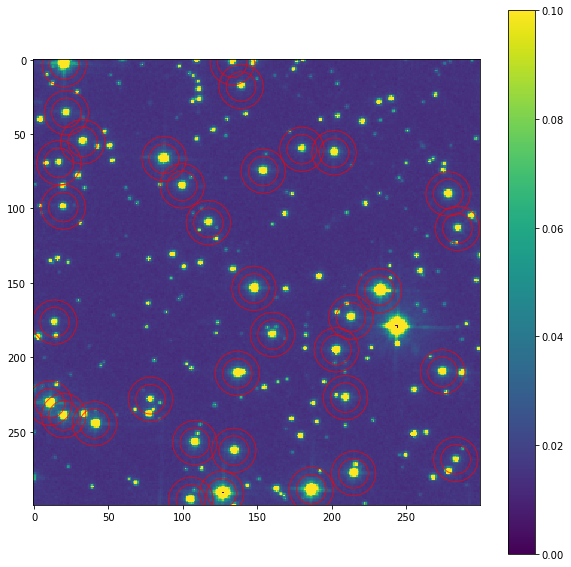

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import CircularAnnulus as CircAn

#%%
hdu = fits.open('HST_Tutorial/M13.fits')
img = hdu[0].data[900:1200, 900:1200]
# if image value < 10^(-6), replace the pixel as 10^(-6)
img[img < 1.e-6] = 1.e-6

FWHM   = 2.5
sky_th = 500   # sky_th * sky_sigma will be used for detection lower limit
sky_a, sky_m, sky_s  = sigma_clipped_stats(img) # 3-sigma, 5 iters
thresh = sky_th*sky_s

find   = DAOStarFinder(fwhm=FWHM, threshold=thresh,
                       sharplo=0.2, sharphi=1.0,  # default values 
                       roundlo=-1.0, roundhi=1.0, # default values
                       sigma_radius=1.5,          # default values
                       ratio=1.0,                 # 1.0: circular gaussian
                       exclude_border=True)       # To exclude sources near edges
found = find(img)

# Use the object "found" for aperture photometry:
# save XY coordinates:
coord = (found['xcentroid'], found['ycentroid']) 
annul = CircAn(positions=coord, r_in=4*FWHM, r_out=6*FWHM)

#%%
plt.figure(figsize=(10,10))
plt.imshow(img, vmax=0.10)
annul.plot(color='red', lw=1., alpha=0.7)
plt.colorbar()
plt.show()

### Digress: `ApertureMask`

Now that I have annulus, let me get statistics for the annulus. For each annulus, we can use the attribute `.to_mask`. This has an unusual data type, called `ApertureMask`. So we need to learn how to use this. For example, the attribute `.cutout(img)` will give you a part of an image which "contains" the annulus (i.e., a cut out image with size `2*r_out=30` pixels):

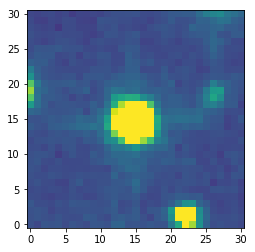

In [18]:
# since our `annul` has many elements, let me use [3] to use only the 4th annulus:
mask_annul = (annul.to_mask(method='center'))[3]
# CAUTION!! YOU MUST USE 'center', NOT 'exact'!!!

cutimg = mask_annul.cutout(img)
plt.imshow(cutimg, vmin=0.005, vmax=0.05, origin='lower')
plt.show()

Also you can "apply" this annulus to the image. You will get an array with the same size as `cutimg` but the pixel values will be 0 outside of this annulus:



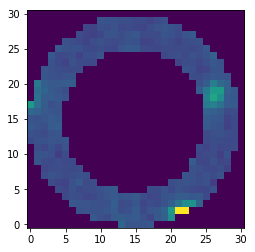

In [19]:
sky_apply  = mask_annul.apply(img)
plt.imshow(sky_apply, origin='lower', vmin=0.005, vmax=0.05)
plt.show()

### Step 4: Sigma Clipping to Sky
We have the annulus pixels. How do we get the statistics? First, save only the non-zero pixels of `sky_apply`. Then calculate statistics (mean, median, standard deviation, etc). Since this part may be tricky to most students, I want to make a useful function for all of you:


In [13]:
import numpy as np
from astropy.stats import sigma_clip



def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5, \
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.

    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)

    Returns
    -------
    sky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    std : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------

    '''
    sky = all_sky.copy()
    if method == 'mean':
        return np.mean(sky), np.std(sky, ddof=1)

    elif method == 'median':
        return np.median(sky), np.std(sky, ddof=1)

    elif method == 'mode':
        sky_clip   = sigma_clip(sky, sigma=sky_nsigma, iters=sky_iter)
        sky_clipped= sky[np.invert(sky_clip.mask)]
        nsky       = np.count_nonzero(sky_clipped)
        mean       = np.mean(sky_clipped)
        med        = np.median(sky_clipped)
        std        = np.std(sky_clipped, ddof=1)
        nrej       = len(all_sky) - len(sky_clipped)

        if nrej < 0:
            raise ValueError('nrej < 0: check the code')

        if nrej > nsky: # rejected > survived
            raise Warning('More than half of the pixels rejected.')

        if mode_option == 'IRAF':
            if (mean < med):
                sky = mean
            else:
                sky = 3 * med - 2 * mean

        elif mode_option == 'MMM':
            sky = 3 * med - 2 * mean

        elif mode_option == 'sex':
            if (mean - med) / std > 0.3:
                sky = med
            else:
                sky = (2.5 * med) - (1.5 * mean)
        else:
            raise ValueError('mode_option not understood')

        return sky, std, nsky, nrej


This code automatically does the sky estimation and gives the sky value, standard deviation, the number of sky pixels used, and the number of rejected sky pixels. So let's test this function for the annulus we just obtained:

In [20]:
sky_apply  = mask_annul.apply(img)
sky_non0   = np.nonzero(sky_apply)
sky_pixel  = sky_apply[sky_non0]
msky, stdev, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')
print(msky, sky_std, nsky, nrej)

0.0158997570903 0.00751938087986 368 25


That is, the representative sky value is `0.01590` electrons per second, with sampel standard deviation `0.00752`, based on 368 sky pixels (25 rejected by 3-sigma 10-iteration clipping).

How can we do it more automatically?

Star ID    msky  s_s     nsky nrej
      0: 0.01530 0.00190  192  31
      1: 0.01794 0.00207  207  27
      2: 0.01512 0.00120  363  28
      3: 0.01590 0.00117  368  25
      4: 0.01570 0.00115  358  34
      5: 0.01478 0.00082  373  21
      6: 0.01493 0.00094  378  15
      7: 0.01602 0.00113  353  37
      8: 0.01574 0.00114  353  40
      9: 0.01485 0.00106  380  12
     10: 0.01536 0.00126  362  29
     11: 0.01523 0.00111  379  16
     12: 0.01516 0.00140  355  38
     13: 0.01488 0.00109  347  47
     14: 0.01547 0.00142  339  58
     15: 0.01532 0.00099  387   6
     16: 0.01883 0.00318  380  13
     17: 0.01657 0.00180  368  25
     18: 0.01472 0.00133  339  47
     19: 0.01502 0.00086  391   3
     20: 0.01555 0.00099  376  17
     21: 0.01540 0.00191  336  54
     22: 0.01531 0.00086  390   5
     23: 0.01496 0.00082  384   7
     24: 0.01525 0.00191  341  52
     25: 0.01919 0.00456  286  51
     26: 0.01800 0.00623  333  60
     27: 0.01657 0.00204  347  45
     28: 0.01

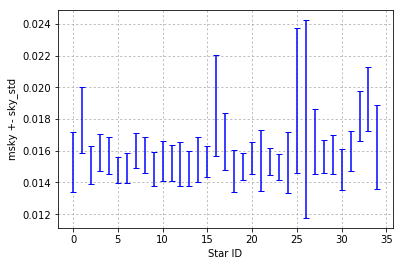

In [33]:
N_stars = len(found)
print('Star ID    msky  s_s     nsky nrej')
for i in range(0, N_stars):
    mask_annul = (annul.to_mask(method='center'))[i]
    sky_apply  = mask_annul.apply(img)
    sky_non0   = np.nonzero(sky_apply)
    sky_pixel  = sky_apply[sky_non0]
    msky, sky_std, nsky, nrej = sky_fit(sky_pixel, method='mode', mode_option='sex')
    print('{0:7d}: {1:.5f} {2:.5f} {3:4d} {4:3d}'.format(i, msky, sky_std, nsky, nrej))
    plt.errorbar([i], msky, yerr=sky_std, capsize=3, color='b')

plt.xlabel('Star ID')
plt.ylabel('msky +- sky_std')
plt.grid(ls=':')
plt.show()

As you can see, the sky can be very uncertain at some positions, but the overall sky value remains relatively constant. If you want to use "constant sky", you may use these realizations as new random variable and use the central limit theorem and estimate the constant sky as `sample_mean +- sample_std` of these 34 `msky` values. Another possibility is to use weighted average. But most cases it is strongly recommended not to use constant sky approximation.